# Simple MAF on images: defining spatial regions through 1-pixel spatial autocorrelation

This notebook decomposes RGB images into their Maximum Autocorrelation Factors, following http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/209/pdf/imm209.pdf and http://www.ccgalberta.com/ccgresources/report10/2008-406_maf.pdf and especially https://statistics.stanford.edu/sites/default/files/SWI%20NSF%2006.pdf

This is done mainly as an exercise for intuitive, visual demonstration of MAF. 

## Importing required libraries
This notebook uses the scikit module `sklearn` as the engine for PCA.  This requires `scipy` and `numpy`.  A few other libraries are required for easy image importing.  `matplotlib` is used for displaying images.

In [1]:
# IMPORTS:

#basics
import sys
import os
import numpy as np

#image import
from scipy import ndimage as ndi

#plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#PCA
from sklearn import decomposition

## An example RGB image and its representation in python

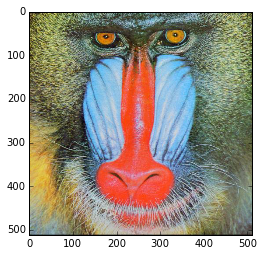

In [2]:
#Show the starting image
baboonfile = '/Users/curt/Downloads/BaboonRGB.jpg'
im = ndi.imread(baboonfile)
plt.imshow(im)

In [3]:
# Verify the image as read by scipy.ndi is a 512x512x3 array of np.uint8s between 0 and 255
print im.shape
print type(im)
print type(im[100,203,2])
print np.max(im), np.min(im)

(512, 512, 3)
<type 'numpy.ndarray'>
<type 'numpy.uint8'>
255 0


## Exploring image shifting in $x$ and $y$:

In [4]:
#Shift image by 1 in x dimension and separately in Y dimension
imX = np.roll(im, 1, axis=0)
imY = np.roll(im, 1, axis=1)

# Reshape both original and shifted image
nx, ny, ncolors = im.shape

imflat = im.reshape(nx*ny, ncolors)
imXflat = imX.reshape(nx*ny, ncolors)
imYflat = imY.reshape(nx*ny, ncolors)

print im.shape, imX.shape, imY.shape

print imflat.shape, imXflat.shape, imYflat.shape

(512, 512, 3) (512, 512, 3) (512, 512, 3)
(262144, 3) (262144, 3) (262144, 3)


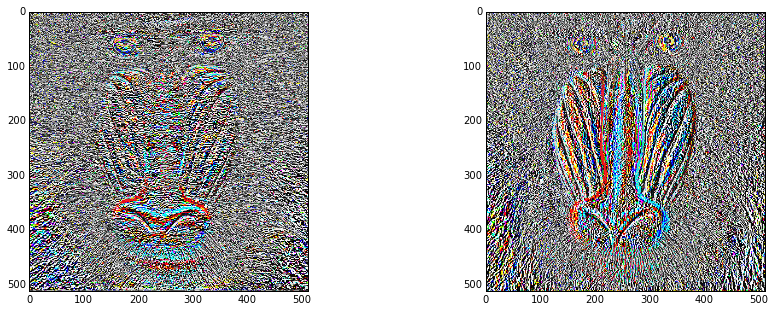

In [5]:
# Show difference image between shifted and original:
f, ax = plt.subplots(1, 2, figsize=[15, 5])
ax[0].imshow((imXflat - imflat).reshape(im.shape))
ax[1].imshow((imYflat - imflat).reshape(im.shape))

The assumption of MAF is that the _signal_ at a pixel is highly correlated with the signal at a neighboring pixel, but the _noise_ at a pixel is uncorrelated with noise at a neighboring pixel.  The signals at neighboring pixels will be correlated in practical data sets when the regions of interest in the image (e.g. anatomical structures or printed spots) are much larger than the average pixel.  The noise will be uncorrelated when each pixel is acquired independently, e.g. from separate laser shots, or during "pushbroom" acquisition of images.  Such noise will be "salt and pepper" noise.  For the test baboon image, the assumptions appear to be largely true: very little signal is apparent in the lagged difference image, and the noise pattern is mainly "salt and pepper" in appearance.  Traces of the original image features (signal) in the lagged difference image indicate that these assumptions are not perfect, however.

## The MAF decomposition 
Notation used here follows the notation from Paul Switzer's original paper as closely as possible.

The data matrix consists of p = 3 spectral channels
The data matrix consists of n = 262144 distinct pixels
[[ 0.3544196   0.57710099  0.73575893]
 [ 0.92096608 -0.07920859 -0.38150686]
 [ 0.16188956 -0.81282252  0.55956351]]


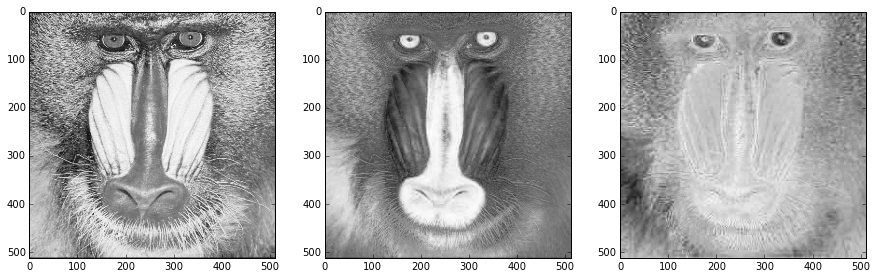

In [6]:
## PCA on the data matrix Z to yield Zstar, a data matrix with an identity-matrix covariance matrix

Z = np.array(imflat.T, dtype=float)
p, n = Z.shape  # p is number of spectral channels, n is number of pixels
Sigma0 = np.cov(Z)
print 'The data matrix consists of p = %s spectral channels' % p
print 'The data matrix consists of n = %s distinct pixels' % n

## The first eigendecomposition done in order to "whiten" the data and form Zstar
lam, V = np.linalg.eig(Sigma0)

## since numpy doesn't return sorted eigenvalues by default, we must reorder:
idx = lam.argsort()[::-1]  # The [::-1] sorts be decreasing rather than increasing order
lam = lam[idx]
V = V[:, idx]

whiteMat = (np.identity(p)*(1/np.sqrt(lam)))
Zstar = np.dot(whiteMat, np.dot(V.T, Z))

## Forming the delta matrices and pooling (adding) them
ZstarFull = Zstar.reshape(im.shape)
ZstarX = np.roll(ZstarFull, 1, axis=0).reshape(Z.shape)
ZstarY = np.roll(ZstarFull, 1, axis=1).reshape(Z.shape)

Sigma1x = np.cov(ZstarX - Z)
Sigma1y = np.cov(ZstarY - Z)
Sigma1 = Sigma1x + Sigma1y


## The second eigendecomposition done on the lagged cross correlation matrix
lam, V = np.linalg.eig(Sigma1)

## since numpy doesn't return sorted eigenvalues by default, we must reorder:
idx = lam.argsort()[::-1]  # The [::-1] sorts be decreasing rather than increasing order
lam = lam[idx]
V = V[:, idx]

print V.T

## tranforming the original data into MAF channels
Y = np.dot(V.T, Z)
Yfull = Y.T.reshape(im.shape)

### normalize each MAF channel to consist of floats between 0 and 1 for compatibility with imshow()
for dim in xrange(0, Yfull.shape[2]):
    Ytemp = Yfull[:, :, dim]
    Ytemp = (Ytemp - Ytemp.min()) / (Ytemp.max() - Ytemp.min())
    Yfull[:, :, dim] = Ytemp

## plotting results
f, ax = plt.subplots(1, 3, figsize = [15, 5])
ax[0].imshow(Yfull[:, :, 0], cmap = cm.Greys_r)
ax[1].imshow(Yfull[:, :, 1], cmap = cm.Greys_r)
ax[2].imshow(Yfull[:, :, 2], cmap = cm.Greys_r)

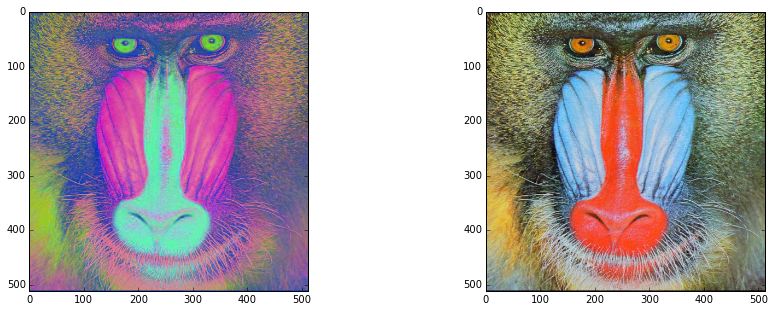

In [15]:
f, ax = plt.subplots(1, 2, figsize = [15, 5])
ax[0].imshow(Yfull)
ax[1].imshow(im)

-0.177094099024 1.1872762244
0.0799828130751 0.93468102656
0.0749738977471 0.922583026005


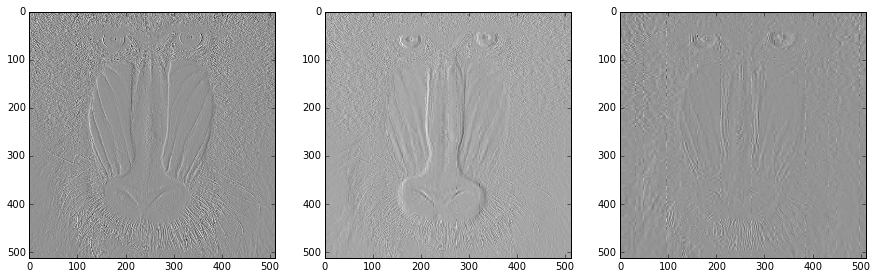

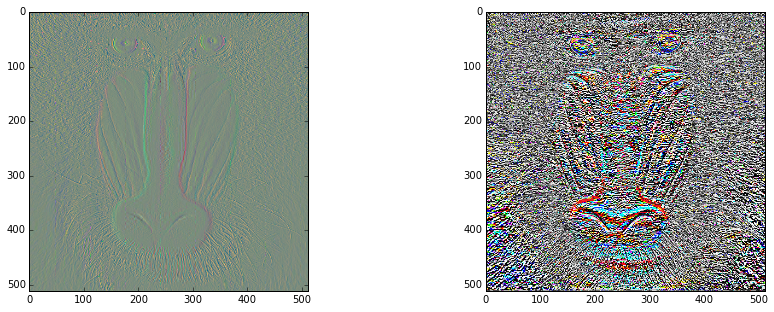

In [20]:
f, ax = plt.subplots(1, 3, figsize = [15, 5])

Ydiff = np.zeros_like(Yfull)

for dim in xrange(0, Yfull.shape[2]):
    diff = Yfull[:, :, dim] - np.roll(Yfull[:, :, dim], 1, axis=1)
    diff = diff - diff.min() / (diff.max() - diff.min())
    print diff.min(), diff.max()
    Ydiff[:, :, dim] = diff
    ax[dim].imshow(diff, cmap = cm.Greys_r, vmin=diff.min(), vmax=diff.max())
    


f2, ax2 = plt.subplots(1, 2, figsize=[15, 5])
ax2[0].imshow(Ydiff)

imXdiff = (imXflat - imflat).reshape(im.shape)

for dim in xrange(0, im.shape[2]):
    mn = imXdiff[:, :, dim].min()
    mx = imXdiff[:, :, dim].max()
    imXdiff[:, :, dim] = imXdiff[:, :, dim] - mn / (mx - mn)

ax2[1].imshow(imXdiff)
